In [13]:
import os

import numpy as np
import pandas
#import seaborn as sns

from sklearn.pipeline import Pipeline, make_union, make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

kf = KFold(n_splits=5, shuffle=True, random_state=421)

import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def load_data_for_kaggle(data_path='DATA'):
    
    data_train = pandas.read_csv(os.path.join(data_path, 'train.csv'))
    data_test = pandas.read_csv(os.path.join(data_path, 'test.csv'))

    X_train = data_train.drop('Survived', axis=1)
    y_train = data_train['Survived'].values
    X_test = data_test
    
    return (X_train, y_train, X_test)

In [15]:
(X_train, y_train, X_test) = load_data_for_kaggle()

In [3]:
def load_data_for_test(data_path='DATA', train_size=0.8):
   
    data = pandas.read_csv(os.path.join(data_path, 'train.csv'))

    X = data.drop('Survived', axis=1)
    y = data['Survived'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    
    return (X_train, X_test, y_train, y_test, X, y)

In [26]:
(X_train, X_test, y_train, y_test, X, y) = load_data_for_test()

## Exploring the Data

In [71]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:
data['Died'] = np.zeros(data.shape[0], dtype=np.uint8)

In [44]:
data.loc[data.Survived == 0, ['Died']] = 1

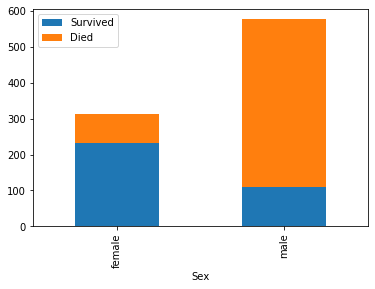

In [45]:
data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked=True)

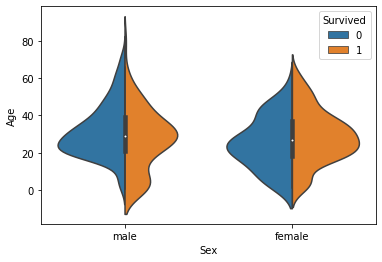

In [46]:
sns.violinplot(x='Sex', y='Age', hue='Survived', data=data, split=True)

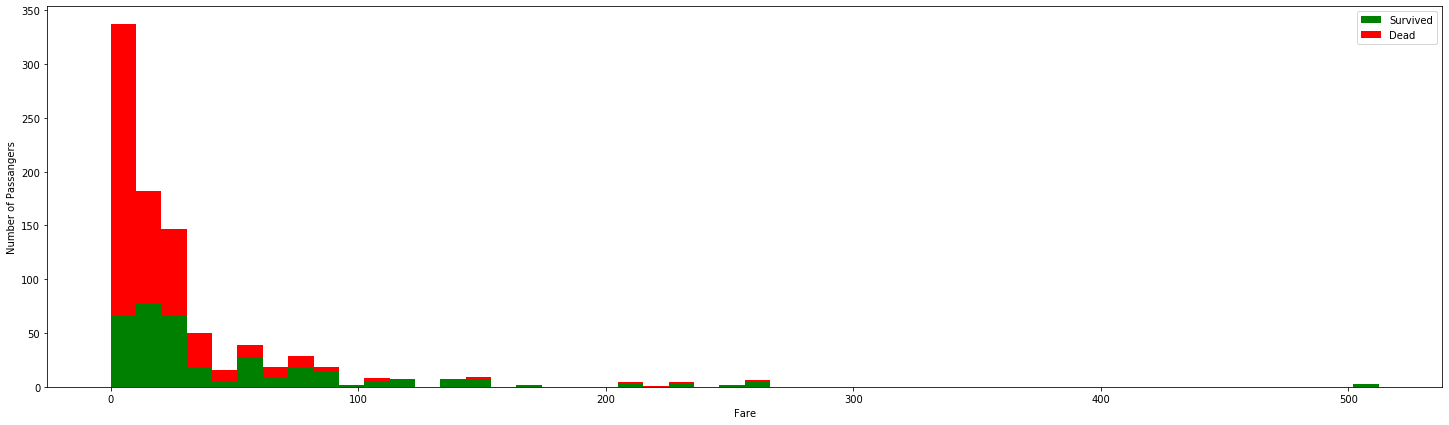

In [47]:
plt.figure(figsize=(25, 7))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']],
        stacked=True, color=['g', 'r'],
        bins=50, label=['Survived', 'Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of Passangers')
plt.legend()

Text(0, 0.5, 'Fare')

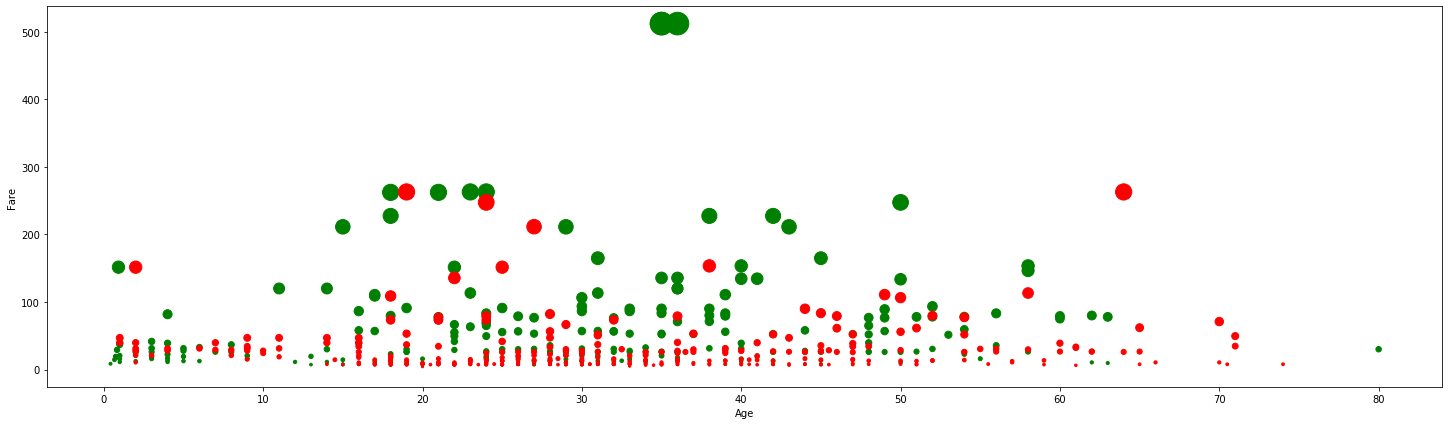

In [48]:
plt.figure(figsize=(25, 7))
ax = plt.subplot()

ax.scatter(data[data['Survived'] == 1]['Age'], data[data['Survived'] == 1]['Fare'],
          c='green', s=data[data['Survived'] == 1]['Fare'])
ax.scatter(data[data['Survived'] == 0]['Age'], data[data['Survived'] == 0]['Fare'],
          c='red', s=data[data['Survived'] == 0]['Fare'])
plt.xlabel('Age')
plt.ylabel('Fare')

## Preprocessing the Data

In [16]:
class FamilyTransform(TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X['FamilySize'] = X['Parch'] + X['SibSp'] + 1

        X['Singleton'] = X['FamilySize'].map(lambda s: 1 if s == 1 else 0)
        X['SmallFamily'] = X['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
        X['BigFamily'] = X['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
        
        #X.drop(['Parch', 'SibSp'], axis=1, inplace=True)
        
        return X
    

def process_family(data):
    
    data['FamilySize'] = data['Parch'] + data['SibSp'] + 1

    data['Singleton'] = data['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    data['SmallFamily'] = data['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    data['BigFamily'] = data['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    data.drop(['Parch', 'SibSp'], axis=1, inplace=True)
    
    return data

In [17]:
class EmbarkedTransform(TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X['Embarked'].fillna('S', inplace=True)

        embarked_dummies = pandas.get_dummies(X['Embarked'], prefix='Embarked')
        X = pandas.concat([X, embarked_dummies], axis=1)
        X.drop('Embarked', axis=1, inplace=True)
        
        return X

def process_embarked(data):

    data['Embarked'].fillna('S', inplace=True)
    
    data_dummies = pandas.get_dummies(data['Embarked'], prefix='Embarked')
    data = pandas.concat([data, data_dummies], axis=1)
    data.drop('Embarked', axis=1, inplace=True)
    
    return data

In [18]:
class CabinTransform(TransformerMixin):
    
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None):
        
        X['Cabin'].fillna('U', inplace=True)
        X['Cabin'] = X['Cabin'].map(lambda c: c[0])

        cabin_dummies = pandas.get_dummies(X['Cabin'], prefix='Cabin')
        X = pandas.concat([X, cabin_dummies], axis=1)

        X.drop('Cabin', axis=1, inplace=True)
        
        return X

def process_cabin(data):
    
    data['Cabin'].fillna('U', inplace=True)
    data['Cabin'] = data['Cabin'].map(lambda c: c[0])
    
    data_dummies = pandas.get_dummies(data['Cabin'], prefix='Cabin')
    data = pandas.concat([data, data_dummies], axis=1)
    
    data.drop('Cabin', axis=1, inplace=True)
    
    return data

In [19]:
titles_dictionary = {
    'Capt': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Jonkheer': 'Royalty',
    'Don': 'Royalty',
    'Sir': 'Royalty',
    'Dr': 'Officer',
    'Rev': 'Officer',
    'the Countess': 'Royalty',
    'Mme': 'Mr',
    'Mlle': 'Miss',
    'Ms': 'Mrs',
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Miss': 'Miss',
    'Master': 'Master',
    'Lady': 'Royalty',
}

class TitleTransform(TransformerMixin):

    def fit(self, X, y=None):
        
        self.titles = ['Title_{}'.format(s) for s in list(set(titles_dictionary.values()))]
        
        return self
    
    def transform(self, X, y=None):
        
        X['Title'] = X['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
        X['Title'] = X.Title.map(titles_dictionary)
        

        return X

def process_titles(data):
    
    data['Title'] = data['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
    data['Title'] = data.Title.map(titles_dictionary)
    
    return data

In [ ]:
grouped_data = X_train.groupby(['Sex', 'Pclass', 'Title'])
grouped_median_train = grouped_data.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
grouped_median_train.head()

In [20]:
class AgeTransform(TransformerMixin):

    def fit(self, X, y=None):
        grouped_data = X.groupby(['Sex', 'Pclass', 'Title'])
        self.grouped_median_age = grouped_data.median()
        self.grouped_median_age = self.grouped_median_age.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
        
        return self
        
    def transform(self, X, y=None):
        
        X['Age'] = X.apply(lambda row: self._fill_age_(row) if np.isnan(row['Age']) else row['Age'], axis=1)

        return X
    
    def _fill_age_(self, row):
        condition = (
            (self.grouped_median_age['Sex'] == row['Sex']) &
            (self.grouped_median_age['Pclass'] == row['Pclass']) &
            (self.grouped_median_age['Title'] == row['Title'])
        )
        if np.isnan(self.grouped_median_age[condition]['Age'].values[0]):
            condition = (
                (self.grouped_median_age['Sex'] == row['Sex']) &
                (self.grouped_median_age['Pclass'] == row['Pclass'])
            )

        return self.grouped_median_age[condition]['Age'].values[0]
        

def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) &
        (grouped_median_train['Pclass'] == row['Pclass']) &
        (grouped_median_train['Title'] == row['Title'])
    )
    if np.isnan(grouped_median_train[condition]['Age'].values[0]):
        condition = (
            (grouped_median_train['Sex'] == row['Sex']) &
            (grouped_median_train['Pclass'] == row['Pclass'])
        )
        
    return grouped_median_train[condition]['Age'].values[0]

def process_age(data):
    
    data['Age'] = data.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    
    return data

In [21]:
class NameTransform(TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X.drop('Name', axis=1, inplace=True)
    
        titles_dummies = pandas.get_dummies(X['Title'], prefix='Title')
        X = pandas.concat([X, titles_dummies], axis=1)
        X.drop('Title', axis=1, inplace=True)

        return X

def proccess_name(data):
    
    data.drop('Name', axis=1, inplace=True)
    
    titles_dummies = pandas.get_dummies(data['Title'], prefix='Title')
    data = pandas.concat([data, titles_dummies], axis=1)
    data.drop('Title', axis=1, inplace=True)
    
    return data

In [22]:
class BinaryTransform(TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X['Sex'] = X['Sex'].map(lambda sex: 1 if sex == 'male' else 0)
        
        return X

In [36]:
class DroppingTranform(TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Parameters that have the biggest weights, while others can be ignored
        important_cols = ['Title_Mr', 'Sex', 'Fare', 'PassengerId', \
                          'Age', 'Pclass', 'FamilySize', 'Cabin_T', 'BigFamily', \
                          'Title_Miss', 'SibSp', 'Title_Officer']
    
        df = pandas.DataFrame()
        for col in important_cols:
            df[col] = X[col]
            
        return df

In [37]:
preprocess_pipeline = Pipeline(steps=[
    ('family', FamilyTransform()),
    ('embarked', EmbarkedTransform()),
    ('cabin', CabinTransform()),
    ('title', TitleTransform()),
    ('age', AgeTransform()),
    ('name', NameTransform()),
    ('binary', BinaryTransform()),
    ('drop', DroppingTranform()),
])

In [124]:
(X_train, y_train, X_test) = load_data_for_kaggle()

In [125]:
X = pandas.concat([X_train, X_test], axis=1)

In [129]:
X.shape

(891, 22)

In [130]:
X_train = preprocess_pipeline.fit_transform(X_train)

In [40]:
X_train.head()

,Title_Mr,Sex,Fare,PassengerId,Age,Pclass,FamilySize,Cabin_T,BigFamily,Title_Miss,SibSp,Title_Officer
0,1,1,7.2500,1,22.0,3,2,0,0,0,1,0
1,0,0,71.2833,2,38.0,1,2,0,0,0,1,0
2,0,0,7.9250,3,26.0,3,1,0,0,1,0,0
3,0,0,53.1000,4,35.0,1,2,0,0,0,1,0
4,1,1,8.0500,5,35.0,3,1,0,0,0,0,0


## Random Forest

In [4]:
param_grid = {'n_estimators':np.arange(10, 100),'max_depth':np.arange(1, 10)}

In [7]:
grid = GridSearchCV(RandomForestClassifier(), param_grid, verbose=2)

In [11]:
grid.fit(X_train, y_train)

/anaconda3/envs/python-cvcourse/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 810 candidates, totalling 2430 fits
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV] ..................... max_depth=1, n_estimators=10, total=   0.0s
[CV] max_depth=1, n_estimators=11 ....................................
[CV] ..................... max_depth=1, n_estimators=11, total=   0.0s
[CV] max_depth=1, n_estimators=11 ....................................
[CV] ..................... max_depth=1, n_estimators=11, total=   0.0s
[CV] max_depth=1, n_estimators=11 ....................................
[CV] ..................... max_depth=1, n_estimators=11, total=   0.0s
[CV] max_depth=1, n_estimators=12 ....................................
[CV] ........

[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:  1.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_sco...
                         'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35,

In [12]:
grid.best_params_

{'max_depth': 6, 'n_estimators': 28}

In [ ]:
# n_estimators=180, min_samples_leaf=3, max_features=0.5, n_jobs=-1

In [39]:
clf = RandomForestClassifier(n_estimators=180, min_samples_leaf=3, max_features=0.5, n_jobs=-1)

In [40]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [41]:
cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy').mean()

0.8305442219571904

In [77]:
df_output = pandas.read_csv(os.path.join('DATA', 'gender_submission.csv'))
df_output['Survived'] = y_pred

In [78]:
df_output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [79]:
df_output.to_csv('submission.csv', index=False)

In [67]:
import argparse
parser = argparse.ArgumentParser(description='Using Tensorflow and and SciKit-Learn \
                                              for solving Kaggle`s Titanic problem.')

parser.add_argument('-tf', '--tensor-flow', help='use Tensorflow', action='store_true')
parser.add_argument('-m', '--model', help='path to the model')

_StoreAction(option_strings=['-m', '--model'], dest='model', nargs=None, const=None, default=None, type=None, choices=None, help='path to the model', metavar=None)

In [68]:
args = vars(parser.parse_args(['-tf',]))

In [69]:
args

{'tensor_flow': True, 'model': None}

# Implementation with Tensorflow

In [12]:
from collections import namedtuple
import numpy.random as rnd
import numpy
import tensorflow as tf

In [70]:
X_train.head()

,Title_Mr,Sex,Fare,PassengerId,Age,Pclass,FamilySize,Cabin_T,BigFamily,Title_Miss,SibSp,Title_Officer
0,1,1,7.2500,1,22.0,3,2,0,0,0,1,0
1,0,0,71.2833,2,38.0,1,2,0,0,0,1,0
2,0,0,7.9250,3,26.0,3,1,0,0,1,0,0
3,0,0,53.1000,4,35.0,1,2,0,0,0,1,0
4,1,1,8.0500,5,35.0,3,1,0,0,0,0,0


In [142]:
tf.reset_default_graph()

X = X_train

learning_rate = 0.01
n_inputs = X.shape[1]
n_hidden = 150

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
y = tf.placeholder(tf.float32, shape=(None, 1))

training = tf.placeholder_with_default(True, shape=(), name="training")
initializer = tf.contrib.layers.xavier_initializer()

hidden = tf.layers.dense(X, n_hidden, activation=None, \
                         kernel_initializer=initializer, name="hidden")
hidden = tf.layers.batch_normalization(hidden, training=training)
hidden = tf.nn.relu(hidden)

logits = tf.layers.dense(hidden, 1, activation=None)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

outputs = tf.nn.sigmoid(logits, name="outputs")
correct = tf.equal(tf.round(outputs), y)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [143]:
import sys

In [144]:
y_train = y_train.reshape((-1, 1))

In [151]:
n_epochs = 210
batch_size = 80

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = X_train.shape[0] // batch_size
        for X_batch, y_batch in get_batch(X_train, y_train):
            if epoch % 40 == 0:
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()

            feed_dict = {
                X: X_batch,
                y: y_batch,
                training: True,
            }
            sess.run(training_op, feed_dict=feed_dict)
        loss_train = loss.eval(feed_dict=feed_dict)
        
        if epoch % 40 == 0:
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_titanic.ckpt")

0 Train MSE: 0.33312565
40 Train MSE: 0.28960398
80 Train MSE: 0.207044
120 Train MSE: 0.16735084
160 Train MSE: 0.13456485
200 Train MSE: 0.11068386


In [153]:
X_test = X_train[-100:]

In [154]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_titanic.ckpt")
    y_pred = sess.run(tf.cast(tf.round(outputs), dtype=tf.int32), feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_titanic.ckpt


In [155]:
y_pred.shape

(100, 1)

In [156]:
y_pred[:5]

array([[1],
       [1],
       [1],
       [0],
       [0]], dtype=int32)